# Compare methods with optimize parameters in ref_case

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import hvplot.xarray
import hvplot.pandas

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

import hvplot.xarray
import hvplot.pandas
import holoviews as hv

import pynsitu as pyn
import lib as lib
from lib import KEYS, raw_dir, images_dir
import os
from glob import glob

import synthetic_traj as st

from synthetic_traj import (
    synthetic_traj,
    noise_irregular_sampling,
    ref_case,
    typical_case,
)

/Users/mdemol/opt/anaconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:55: UserWarning: ipyleaflet not available
  warnings.warn("ipyleaflet not available")
/Users/mdemol/opt/anaconda3/envs/mdenv/lib/python3.9/site-packages/pyTMD/tools.py:56: UserWarning: Some functions will throw an exception if called
  warnings.warn("Some functions will throw an exception if called")


In [2]:
def ms_diff(DF, true_key, var=["x", "y", "u", "v", "ax", "ay", "X", "U", "Axy"]):
    DF = DF.copy()
    dft = DF[true_key]
    dft_ = (dft.set_index("id")[var]).groupby("id").var()
    dfms = pd.DataFrame(index=DF.keys(), columns=var)
    dfmsr = pd.DataFrame(index=DF.keys(), columns=var)
    for l in DF:
        df = DF[l]
        if np.all(df.index.values == dft.index.values):
            df_ = df.set_index("id")[var] - dft.set_index("id")[var]
            # dfr_ = (df.set_index('id')[var]-dft.set_index('id')[var])/dft.set_index('id')[var]
            dfms.loc[l] = df_.groupby("id").var().mean()
            dfmsr.loc[l] = (df_.groupby("id").var() / dft_).mean()
        else:
            print(l + " has not the same time index")
            continue
    dfms = pd.concat(
        [dfms, dfmsr.rename(columns={v: "ratio_" + v for v in var})], axis=1
    ).dropna()
    return dfms

___________
# Reference case + centered_diff

In [3]:
N = 100
acc_cut = 1e-3
position_noise = 20
ntype = "white_noise"
offset_type = "svp_scripps_10"
dt_smooth = "30min"
true_key = "True_" + dt_smooth
spectral_diff = False
ref_case["spectral_diff"] = spectral_diff
print(ref_case)

{'T': 5, 'U_low': 0.3, 'U_ni': 0.2, 'U_2': 0, 'U_1': 0, 'tau_eta': 0.1, 'n_layers': 5, 'spectral_diff': False}


In [4]:
DF = dict()

# TRUE
t = (
    50,
    "1min",
)  # use it instead of (50, 1/24/60 because otherwise not regularly sampled
dst = synthetic_traj(t, N, **ref_case)  # u,v, ax, ay computed
dft = st.dataset2dataframe(dst).rename(columns={"draw": "id"})
DF["True_1min"] = dft

# OBSERVED
dso = noise_irregular_sampling(
    dst, t, position_noise, ntype=ntype, offset_type=offset_type, istart=6097
)
dfo = st.dataset2dataframe(dso).rename(columns={"draw": "id"})
dfo = dfo.groupby("id").apply(pyn.geo.compute_dt, time="index")


DF["Observed"] = dfo

# Interpolated True
dsti = dst.sel(time=pd.date_range(dfo.index.min(), dfo.index.max(), freq=dt_smooth))
dsti["dt"] = dsti.time.diff("time") / pd.Timedelta("1s")
st.add_position_noise(
    dsti, dsti.time, position_noise, ntype=ntype, inplace=True
)  # adding noise
dsti["u_noise"] = dsti.x_noise.differentiate("time", datetime_unit="s")
dsti["v_noise"] = dsti.y_noise.differentiate("time", datetime_unit="s")
dfti = st.dataset2dataframe(dsti).rename(columns={"draw": "id"})
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_velocities,
    time="index",
    distance="xy",
    names=("u", "v", "U"),
    fill_startend=True,
    centered=True,
    keep_dt=True,
)
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_accelerations,
    from_=("xy", "x", "y"),
    names=("ax", "ay", "Axy"),
    keep_dt=True,
)
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_accelerations,
    from_=("xy", "x_noise", "y_noise"),
    names=("ax_noise", "ay_noise", "Axy_noise"),
    keep_dt=True,
)
dsti = dfti.reset_index().set_index(["time", "id"]).to_xarray()

DF["True_" + dt_smooth] = dfti

centred diff
centred diff
-13394.13809599266
6097


In [50]:
parameters_lowess = dict(degree=2)
cutoff_list = np.arange(2, 24, 0.5)

dfl = pyn.drifters.smooth_all(
    dfo,
    "lowess",
    dt_smooth,
    parameters=parameters_lowess,
    spectral_diff=spectral_diff,
    geo=False,
)
DF["LOWESS"] = dfl
for cutoff in cutoff_list:
    DF[cutoff] = dfl.groupby("id").apply(pyn.drifters.posteriori_low_pass, T=15, cutoff=cutoff)
    print("ok")

ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


___________
# MS

In [51]:
dfms = ms_diff(DF, true_key="True_" + dt_smooth).astype(float)
dfr = dfms[[l for l in dfms.columns if "ratio_" in l]]
dfr = dfr.rename(columns={l: l.replace("ratio_", "") for l in dfr.columns}) * 100

True_1min has not the same time index
Observed has not the same time index


In [53]:
dfr.loc['LOWESS']

x       0.000009
y       0.000008
u       0.022824
v       0.022387
ax     20.476391
ay     19.786382
X       0.000008
U       0.046092
Axy    71.812792
Name: LOWESS, dtype: float64

In [59]:
dfr_ = dfr_.sort_index()

In [85]:
dfr_=dfr_[2:]

In [54]:
dfr_ = dfr.iloc[2:]

In [55]:
dfr_.index = dfr_.index.astype(float)

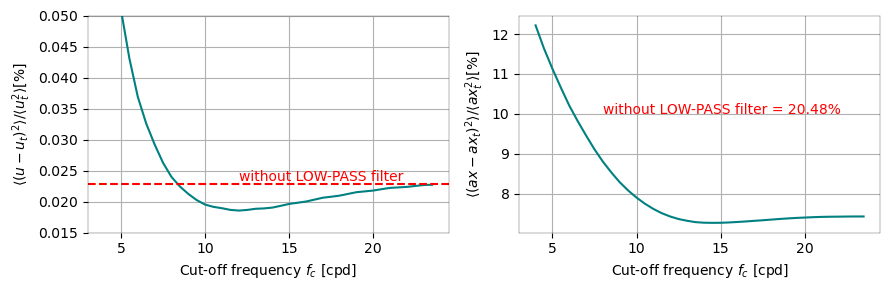

In [99]:
fig, axs = plt.subplots(1,2, figsize=(9,3))
axs = axs.flatten()
#ax = axs[0]
#dfr_.x.plot(color='teal', ax=ax)
#ax.axhline(dfr.loc['LOWESS'].x, color='r', ls='--', label='LOWESS without Low-pass filter')
#ax.set_ylim(5e-6,3e-5)
#var = 'x'
#ax.set_ylabel(rf"$\langle ({var}-{var}_t)^2 \rangle / \langle {var}_t^2 \rangle [\%]$")

ax = axs[0]
dfr_.u.plot(color='teal', ax=ax)
ax.axhline(dfr.loc['LOWESS'].u, color='r', ls='--')
ax.annotate('without LOW-PASS filter', (12,dfr.loc['LOWESS'].u+5e-4), color='r')
ax.set_ylim(0.015,0.05)
var = 'u'
ax.set_ylabel(rf"$\langle ({var}-{var}_t)^2 \rangle / \langle {var}_t^2 \rangle [\%]$")
ax = axs[1]
dfr_.ax.plot(color='teal', ax=ax)
#ax.axhline(dfr.loc['LOWESS'].ax, color='r', ls='--')
a=np.round(dfr.loc['LOWESS'].ax, 2)
ax.annotate(f'without LOW-PASS filter = {a}%', (8, 10), color='r')
var = 'ax'
ax.set_ylabel(rf"$\langle ({var}-{var}_t)^2 \rangle / \langle {var}_t^2 \rangle [\%]$")
#ax.set_ylim(0,0.05)
for ax in axs :
    ax.grid()
    ax.set_xlabel(r'Cut-off frequency $f_c$ [cpd]')
fig.tight_layout()
path = os.path.join(images_dir, "comp_lowess_cutoff_ref_case.png")
fig.savefig(path, dpi=250)

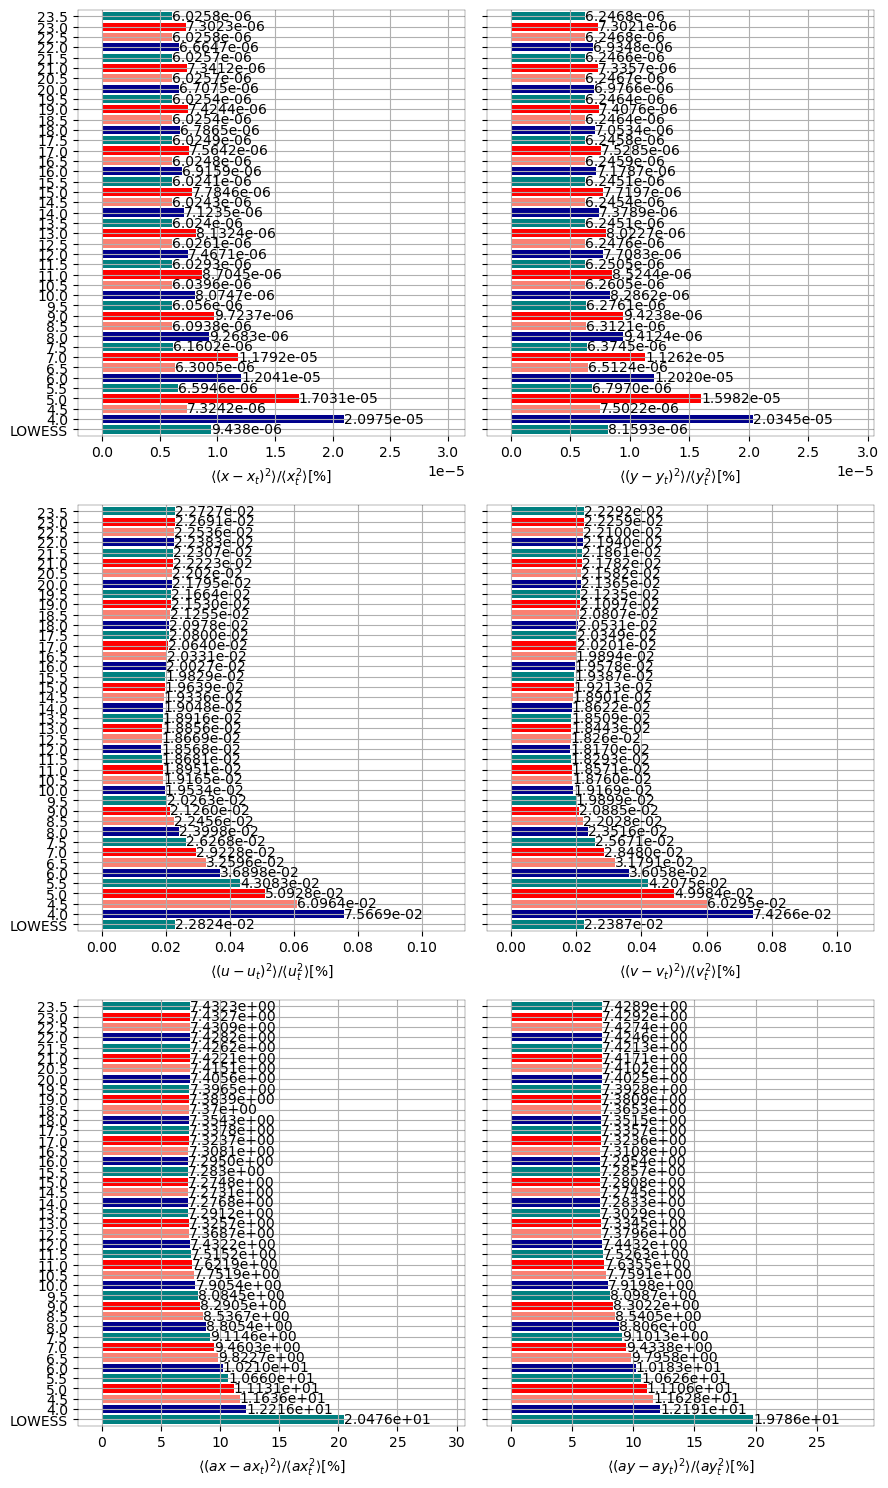

In [27]:
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(9, 15))
i = 0
axs = axs.flatten()
for var in [
    "x",
    "y",
    "u",
    "v",
    "ax",
    "ay",
]:
    ax = axs[i]
    dfr[var].plot.barh(ax=ax, color=["teal", "darkblue", "salmon", "r"], width=0.8)
    ax.grid()
    ax.set_xlim(-0.1 * dfr[var].max(), dfr[var].max() * 1.5)
    i += 1
    ax.set_xlabel(
        rf"$\langle ({var}-{var}_t)^2 \rangle / \langle {var}_t^2 \rangle [\%]$"
    )
    ax.bar_label(
        ax.containers[0],
        labels=[
            np.format_float_scientific(l, precision=4, exp_digits=2)
            for l in dfr[var].values
        ],
    )
fig.tight_layout()
# fig.suptitle('refcase =' +str(ref_case) + '\n spydell ' +str(parameters_spydell)+'\n variational '+str(parameters_var)+'\n lowess '+str(parameters_lowess),
#            x= 0.5, y=-0.02, fontsize=8)
path = os.path.join(images_dir, "comp_method_ref_case.png")
fig.savefig(path, dpi=250)

In [28]:
dfr[dfr.u == dfr.u.min()]

x         y         u        v       ax        ay         X  \
12.0  0.000007  0.000008  0.018568  0.01817  7.43218  7.443211  0.000005   

             U        Axy  
12.0  0.037688  18.237914

In [29]:
dfr[dfr.v == dfr.v.min()]

x         y         u        v       ax        ay         X  \
12.0  0.000007  0.000008  0.018568  0.01817  7.43218  7.443211  0.000005   

             U        Axy  
12.0  0.037688  18.237914

In [30]:
dfr[dfr.ax == dfr.ax.min()]

x         y         u         v        ax        ay         X  \
14.5  0.000006  0.000006  0.019336  0.018901  7.273099  7.274534  0.000004   

             U        Axy  
14.5  0.039062  18.067185

In [31]:
dfr[dfr.ay == dfr.ay.min()]

x         y         u         v        ax        ay         X  \
14.5  0.000006  0.000006  0.019336  0.018901  7.273099  7.274534  0.000004   

             U        Axy  
14.5  0.039062  18.067185

___________
# Spectra

In [7]:
DF0 = DF.copy()
DF0.pop("True_1min")
DSE = st.spectrum_DF(DF0, nperseg="20D", detrend="linear")

True_30min
LOWESS
Variational
Spydell


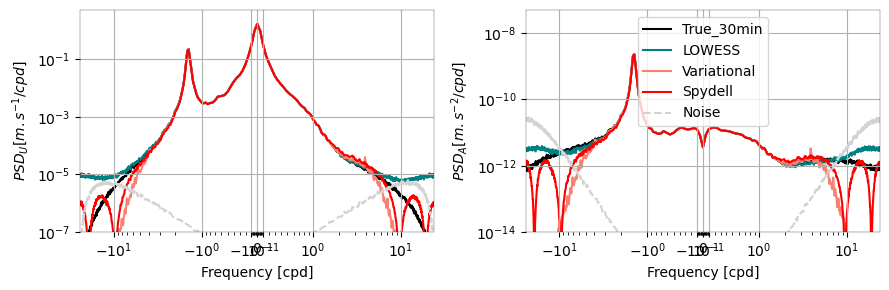

In [8]:
linthresh = 5e-1
linscale = 0.3

zorder = {"True_1min": 0, "True_30min": 0, "LOWESS": 1, "Variational": 1, "Spydell": 1}

fig, axs = plt.subplots(1, 2, figsize=(9, 3))
ax = axs[0]
for l in DSE.keys():
    DSE[l].u_v.mean("id").plot(
        ax=ax,
        label=l,
        color=color[l],
        zorder=zorder[l],
    )
DSE["True_30min"].u_noise_v_noise.mean("id").plot(
    ax=ax, color="lightgrey", ls="--", label="Noise"
)


ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
ax.set_ylim(1e-7, 5e0)
ax.set_ylabel(r"$PSD_{U} [m.s^{-1}/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))

ax = axs[1]
for l in DSE.keys():
    DSE[l].ax_ay.mean("id").plot(
        ax=ax,
        label=l,
        color=color[l],
        zorder=zorder[l],
    )
DSE["True_30min"].ax_noise_ay_noise.mean("id").plot(
    ax=ax, color="lightgrey", ls="--", label="Noise"
)
ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
ax.set_ylim(1e-14, 5e-8)
ax.set_ylabel(r"$PSD_{A} [m.s^{-2}/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))
ax.legend()
fig.tight_layout()
fig.savefig(
    os.path.join(images_dir, "comp_opt_spectra.png"), dpi=200, bbox_inches="tight"
)

In [9]:
DF_diff = st.build_DF_diff(DF0, true_key="True_30min")
DSE_d = st.spectrum_DF(DF_diff)

Observed has not the same time index
LOWESS
Variational
Spydell


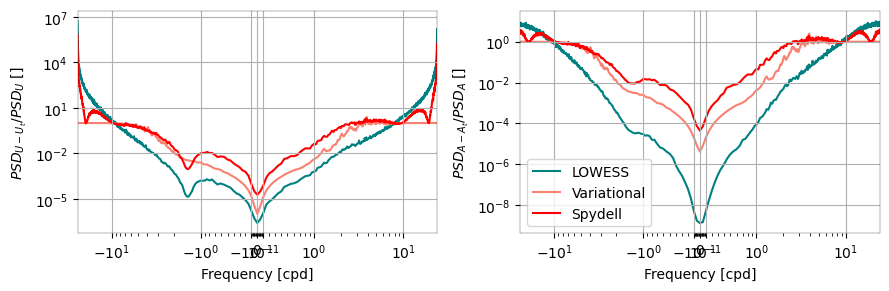

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
ax = axs[0]
for l in DSE_d.keys():
    (DSE_d[l].u_v / DSE["True_30min"].u_v).mean("id").plot(
        ax=ax, color=color[l], zorder=zorder[l], label=l
    )
ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
# ax.set_ylim(1e-7, 5e0)
ax.set_ylabel(r"$PSD_{U-U_t}/PSD_{U}$ []")
ax.set_xlabel("Frequency [cpd]")
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))

ax = axs[1]
for l in DSE_d.keys():
    (DSE_d[l].ax_ay / DSE["True_30min"].ax_ay).mean("id").plot(
        ax=ax, color=color[l], zorder=zorder[l], label=l
    )
ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
# ax.set_ylim(5e-13, 1e-5)
ax.set_ylabel(r"$PSD_{A-A_t}/PSD_{A}$ []")
ax.set_xlabel("Frequency [cpd]")
ax.legend()
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))

fig.tight_layout()
fig.savefig(
    os.path.join(images_dir, "comp_opt_diffspectra_normed.png"),
    dpi=200,
    bbox_inches="tight",
)

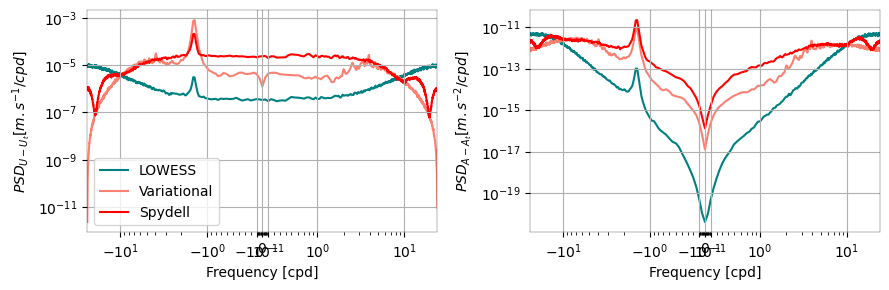

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
ax = axs[0]
# DSE_d.pop('nb_pt_mean =9')
for l in DSE_d.keys():
    DSE_d[l].u_v.mean("id").plot(ax=ax, color=color[l], zorder=zorder[l], label=l)
ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
# ax.set_ylim(1e-7, 5e0)
ax.set_ylabel(r"$PSD_{U-U_t} [m.s^{-1}/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))
ax.legend()

ax = axs[1]
for l in DSE_d.keys():
    DSE_d[l].ax_ay.mean("id").plot(ax=ax, color=color[l], zorder=zorder[l], label=l)
ax.grid()
ax.set_xscale("symlog", linthresh=linthresh, linscale=linscale)
ax.set_yscale("log")
ax.set_xlim(-24 * 60 / 30 / 2, 24 * 60 / 30 / 2)
# ax.set_ylim(5e-13, 1e-5)
ax.set_ylabel(r"$PSD_{A-A_t} [m.s^{-2}/cpd]$")
ax.set_xlabel("Frequency [cpd]")
ax.xaxis.set_minor_locator(lib.MinorSymLogLocator(1e-1))

fig.tight_layout()
fig.savefig(
    os.path.join(images_dir, "comp_opt_diffspectra.png"), dpi=200, bbox_inches="tight"
)

True_30min
LOWESS
Variational
Spydell
True_30min
LOWESS
Variational
Spydell


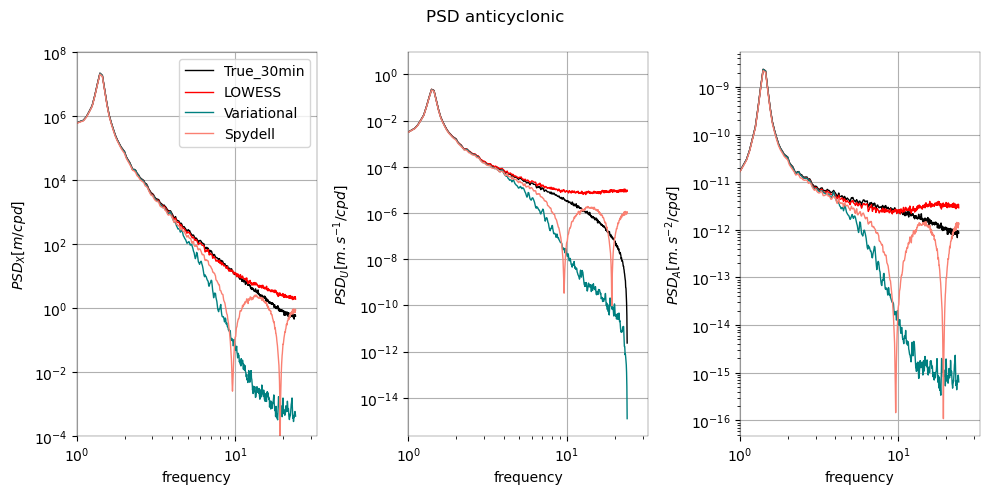

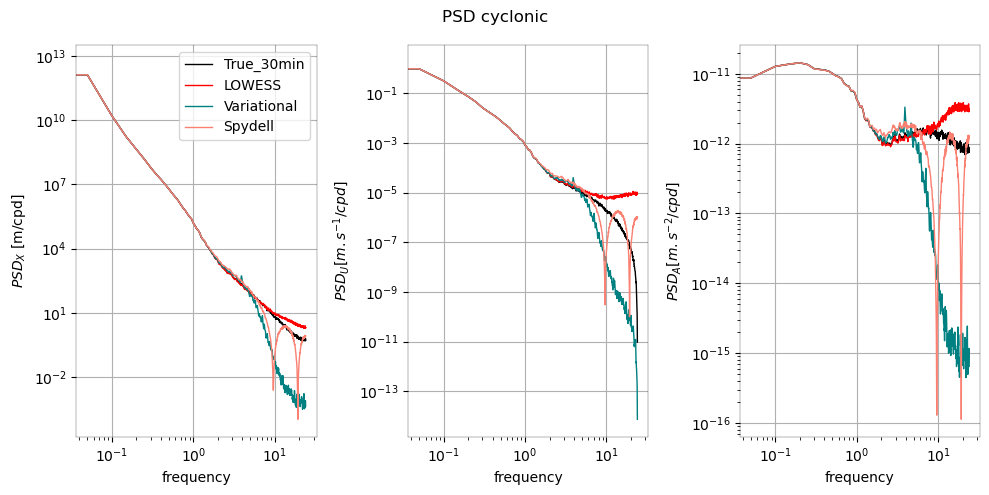

In [53]:
# DF.pop('True_1min')
DSE = st.spectrum_DF(DF, nperseg="20D", detrend="linear")
dse = st.DSE2dse(DSE)
dsen, dsep = st.negpos_spectra(dse)
co = {"True_30min": "k", "LOWESS": "r", "Variational": "teal", "Spydell": "salmon"}

fig4, axs = plt.subplots(1, 3, figsize=(10, 5))

for l in dsen.Trajectory.values:
    print(l)
    dsen.x_y.mean("id").sel(Trajectory=l).plot(
        ax=axs[0], add_legend=True, lw=1, color=co[l], label=l
    )
    dsen.u_v.mean("id").sel(Trajectory=l).plot(
        ax=axs[1], add_legend=False, lw=1, color=co[l]
    )
    dsen.ax_ay.mean("id").sel(Trajectory=l).plot(
        ax=axs[2], add_legend=False, lw=1, color=co[l]
    )

for ax in axs:
    ax.grid()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title("")
    ax.set_xlim(1)
axs[0].set_ylabel(r"$PSD_X [m/cpd]$")
axs[1].set_ylabel(r"$PSD_U [m.s^{-1}/cpd]$")
axs[2].set_ylabel(r"$PSD_A [m.s^{-2}/cpd]$")
axs[0].set_ylim(1e-4, 1e8)
axs[1].set_ylabel(r"$PSD_U [m.s^{-1}/cpd]$")
axs[2].set_ylabel(r"$PSD_A [m.s^{-2}/cpd]$")
axs[0].legend()

fig4.suptitle("PSD anticyclonic")
fig4.tight_layout()
path = os.path.join(images_dir, "comp_method_ref_case_spectra_neg.png")
fig4.savefig(path, dpi=250)

fig4, axs = plt.subplots(1, 3, figsize=(10, 5))

for l in dsep.Trajectory.values:
    dsep.x_y.mean("id").sel(Trajectory=l).plot(
        ax=axs[0], add_legend=True, lw=1, color=co[l], label=l
    )
    dsep.u_v.mean("id").sel(Trajectory=l).plot(
        ax=axs[1], add_legend=False, lw=1, color=co[l]
    )
    dsep.ax_ay.mean("id").sel(Trajectory=l).plot(
        ax=axs[2], add_legend=False, lw=1, color=co[l]
    )
for ax in axs:
    ax.grid()
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title("")
axs[0].legend()
axs[0].set_ylabel(r"$PSD_X$ [m/cpd]")
axs[1].set_ylabel(r"$PSD_U [m.s^{-1}/cpd]$")
axs[2].set_ylabel(r"$PSD_A [m.s^{-2}/cpd]$")

fig4.suptitle("PSD cyclonic")
fig4.tight_layout()
path = os.path.join(images_dir, "comp_method_ref_case_spectra_pos.png")
fig4.savefig(path, dpi=250)

In [14]:
DF_diff = st.build_DF_diff(DF, true_key="True_30min")
# DF.pop('True_1min')
DSE_d = st.spectrum_DF(DF_diff, nperseg="20D", detrend="linear")
dsed = st.DSE2dse(DSE_d)
dsend, dsepd = st.negpos_spectra(dsed)
co = {"True_30min": "k", "LOWESS": "r", "Variational": "teal", "Spydell": "salmon"}

Observed has not the same time index
LOWESS
Variational
Spydell


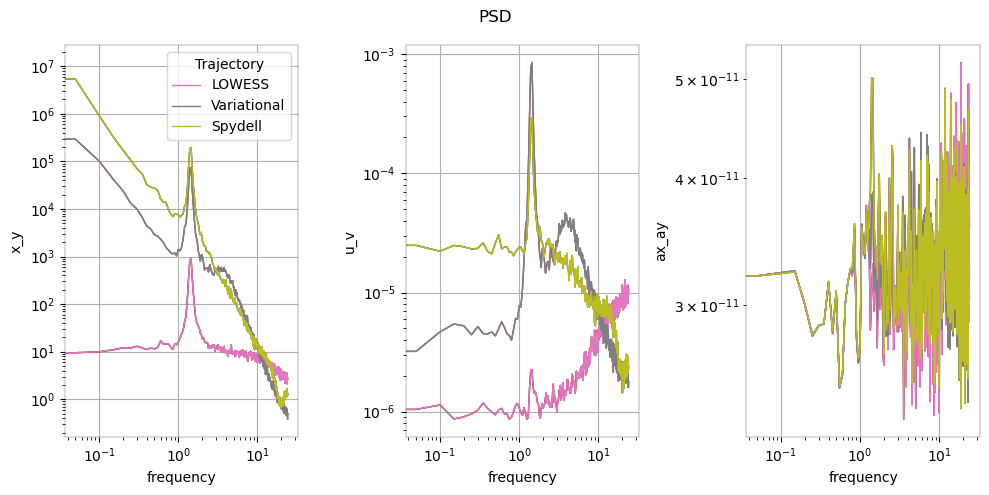

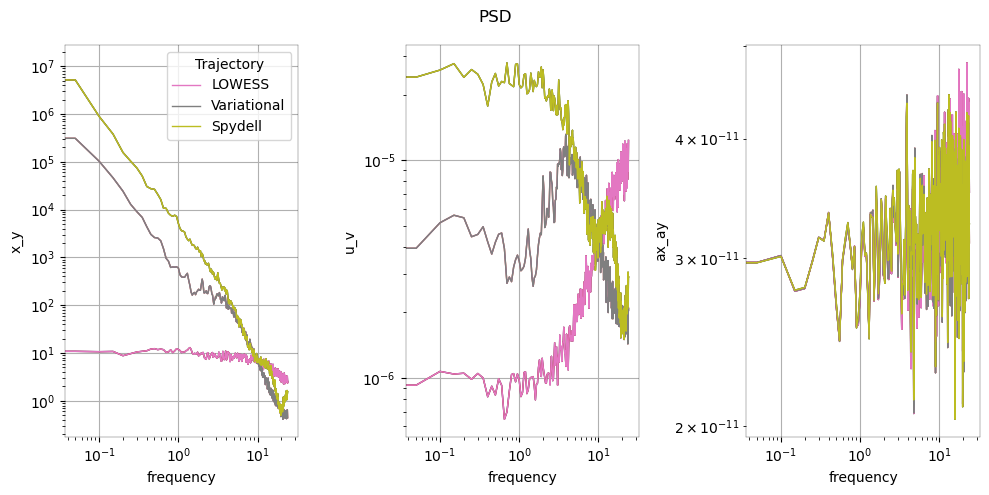

In [15]:
fig4, axs = plt.subplots(1, 3, figsize=(10, 5))

for l in dsend.Trajectory:
    dsend.x_y.mean("id").plot(hue="Trajectory", ax=axs[0], add_legend=True, lw=1)
    dsend.u_v.mean("id").plot(hue="Trajectory", ax=axs[1], add_legend=False, lw=1)
    dsend.ax_ay.mean("id").plot(hue="Trajectory", ax=axs[2], add_legend=False, lw=1)
for ax in axs:
    ax.grid()
    ax.set_xscale("log")
    ax.set_yscale("log")
fig4.suptitle("PSD")
fig4.tight_layout()

fig4, axs = plt.subplots(1, 3, figsize=(10, 5))

for l in dsepd.Trajectory:
    dsepd.x_y.mean("id").plot(hue="Trajectory", ax=axs[0], add_legend=True, lw=1)
    dsepd.u_v.mean("id").plot(hue="Trajectory", ax=axs[1], add_legend=False, lw=1)
    dsepd.ax_ay.mean("id").plot(hue="Trajectory", ax=axs[2], add_legend=False, lw=1)
for ax in axs:
    ax.grid()
    ax.set_xscale("log")
    ax.set_yscale("log")
fig4.suptitle("PSD")
fig4.tight_layout()

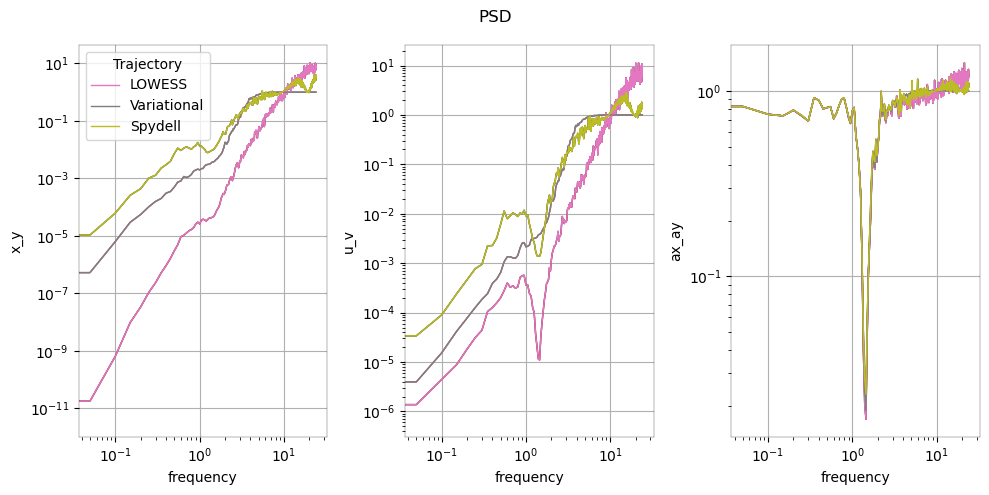

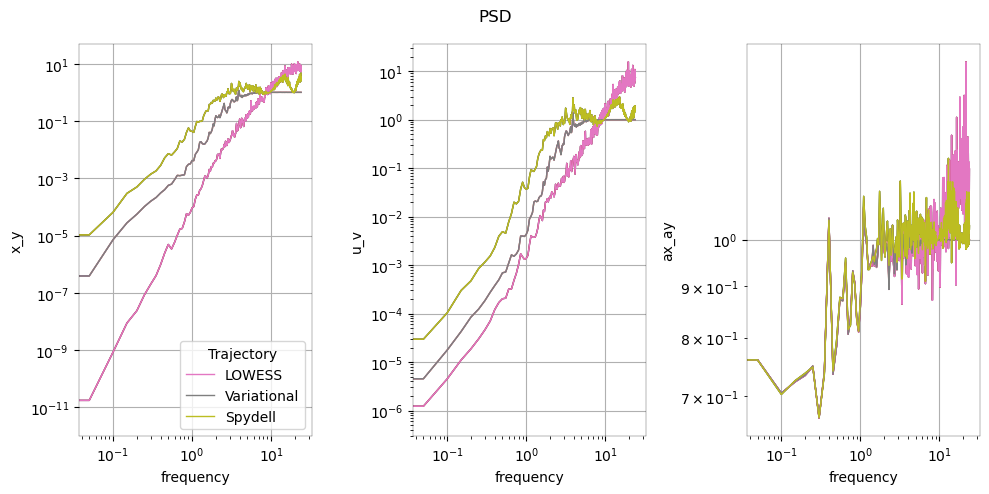

In [16]:
dsend = dsend / dsen.sel(Trajectory="True_30min")
dsepd = dsepd / dsep.sel(Trajectory="True_30min")


fig4, axs = plt.subplots(1, 3, figsize=(10, 5))

for l in dsend.Trajectory:
    dsend.x_y.mean("id").plot(hue="Trajectory", ax=axs[0], add_legend=True, lw=1)
    dsend.u_v.mean("id").plot(hue="Trajectory", ax=axs[1], add_legend=False, lw=1)
    dsend.ax_ay.mean("id").plot(hue="Trajectory", ax=axs[2], add_legend=False, lw=1)
for ax in axs:
    ax.grid()
    ax.set_xscale("log")
    ax.set_yscale("log")
fig4.suptitle("PSD")
fig4.tight_layout()

fig4, axs = plt.subplots(1, 3, figsize=(10, 5))

for l in dsepd.Trajectory:
    dsepd.x_y.mean("id").plot(hue="Trajectory", ax=axs[0], add_legend=True, lw=1)
    dsepd.u_v.mean("id").plot(hue="Trajectory", ax=axs[1], add_legend=False, lw=1)
    dsepd.ax_ay.mean("id").plot(hue="Trajectory", ax=axs[2], add_legend=False, lw=1)
for ax in axs:
    ax.grid()
    ax.set_xscale("log")
    ax.set_yscale("log")
fig4.suptitle("PSD")
fig4.tight_layout()